### Objectifs de cette page: ###
- analyser les données obtenues (voir s'il y a des valeurs manquantes et si cohérence)
- retirer les données inutiles
- créer des 2 sets de données 1min et 5min avec la colonne "high_before_low"
- regarder si la colonne crée semble cohérente 
- générer un backtest pour chaque set de données (peut etre sur une autre page)

# FONCTION DEFINITION

In [3]:
import pandas as pd
import plotly.graph_objects as go

def print_olhc_price_from_df(df_plot, start_date, end_date):

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # 2. Filtrer les prix autour de la période du trade
    df_plot = df_plot[(df_plot['datetime'] >= start_date) & (df_plot['datetime'] <= end_date)]
    # Créer le graphique en chandelier
    fig = go.Figure(data=[go.Candlestick(
        x=df_plot['datetime'],
        open=df_plot['open'],
        high=df_plot['high'],
        low=df_plot['low'],
        close=df_plot['close'],
        name='SP500',
    )])
    # fig.update_xaxes(dtick=1)

    # ➤ Lignes Ichimoku
    fig.add_trace(go.Scatter(x=df_plot['datetime'], y=df_plot['tenkan'], mode='lines', name='Tenkan-sen', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=df_plot['datetime'], y=df_plot['kijun'], mode='lines', name='Kijun-sen', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=df_plot['datetime'], y=df_plot['chikou'], mode='lines', name='Chikou Span', line=dict(color='purple')))

    # ➤ Nuage Ichimoku (Kumo)
    # Span A
    fig.add_trace(go.Scatter(
        x=df_plot['datetime'],
        y=df_plot['ssa'],
        mode='lines',
        name='Senkou Span A',
        line=dict(color='rgba(0,200,0,0.5)'),
        fill=None
    ))
    # Span B avec remplissage
    fig.add_trace(go.Scatter(
        x=df_plot['datetime'],
        y=df_plot['ssb'],
        mode='lines',
        name='Senkou Span B',
        line=dict(color='rgba(200,0,0,0.5)'),
        fill='tonexty',  # crée le nuage entre Span B et la courbe précédente (Span A)
        fillcolor='rgba(100,100,100,0.2)'  # couleur du nuage
    ))

    # ➤ Mise en forme
    fig.update_layout(
        title=f"Prix de {start_date} à {end_date}",
        xaxis_title="Date",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template="plotly_white"
    )
    fig.show()

In [2]:
import pandas as pd

def create_df_from_csv(timeFrameUsed="1m", start_date="2020-03-20 00:00:00", end_date="2025-02-26 12:00:00", 
                       let_original_rangeTime=True):
    
    main_df = pd.DataFrame()
    root_path = "C:/Users/tessa/Codes/Backtest_Trading/market_data/"
    path = root_path+f"ES_{timeFrameUsed}_2-10-2020-12-00PM_3-10-2025-12-00PM.csv"
    
    main_df = pd.read_csv(
        filepath_or_buffer=path,
        usecols=["Time left", "Open", "High", "Low", "Close", "Volume"],
        # names=["datetime", "open", "high", "low","close", "volume","high_before_low"],
        #header=None,
        delimiter=";",
        # dtype={'high_before_low': 'boolean'}
    ).rename(columns={
        'Time left': 'datetime', 
        'Open': 'open',
        "High":'high', 
        "Low":'low',
        "Close":'close', 
        "Volume":'volume'
    }, inplace=False)

    main_df['datetime'] = pd.to_datetime(main_df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

    if not let_original_rangeTime:
        start_date = pd.to_datetime(start_date) 
        end_date = pd.to_datetime(end_date)
        main_df = main_df[(start_date <= main_df['datetime']) & (main_df['datetime'] <= end_date)]
        main_df.reset_index(inplace=True)

    return main_df

In [4]:
def resample_data(df, frequency="1min"):
    # Il doit contenir 'datetime' + ['open', 'high', 'low', 'close']
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # S'assurer que les données sont triées
    df.sort_index(inplace=True)

    # Grouper par date (chaque jour séparé)
    grouped = df.groupby(df.index.date)

    resampled_list = []

    for date, group in grouped:
        #group.index = pd.to_datetime(group.index)  # retransformer l'index en datetime si nécessaire
        # Rééchantillonnage à la minute près pour ce jour-là
        resampled = group.resample(frequency).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last'
        })
        # Ne garder que les minutes où il y avait des données originales
        resampled = resampled.loc[group.index.min():group.index.max()]
        resampled_list.append(resampled)

    # Recombiner tous les jours
    df_resampled = pd.concat(resampled_list)

    # Optionnel : remplir les trous dans les données si besoin
    # df_resampled.fillna(method='ffill', inplace=True)

    # Reset index si tu veux repasser en dataframe "plat"
    df_resampled.reset_index(inplace=True)
    return df_resampled

In [5]:
from tqdm import tqdm

high_before_low_results = []

def high_before_low(df_10s_segment):
    high_index = df_10s_segment['high'].idxmax()
    low_index = df_10s_segment['low'].idxmin()
    bool1 = high_index < low_index
    # print(f"high index = {high_index}, low index = {low_index}")
    # print(bool1)
    return bool1

def create_high_before_low_column(df, df_10s, frequency_of_data=1):
    for timestamp in tqdm(df["datetime"], unit="iteration"):
        # Définir la fenêtre de "frequency_of_data" minutes
        start_time = str(timestamp)
        end_time = str(timestamp + pd.Timedelta(minutes=frequency_of_data))
        df_segment = df_10s.loc[start_time:end_time]
        # df_segment = df_10s[(df_10s['datetime'] >= start_time) & (df_10s['datetime'] < end_time)]
        # print(df_segment)
        if not df_segment.empty:
            high_before_low_results.append(high_before_low(df_segment))

    df['high_before_low'] = high_before_low_results
    return df

In [6]:
def check_resample_null_values(df_original, df_resampled):
    mask_nan = df_resampled.isnull().any(axis=1)
    df_nan = df_resampled[mask_nan]

    timestamps_nan = pd.to_datetime(df_nan['datetime'])  # Assure-toi que c'est bien datetime
    timestamps_nan_absents = ~timestamps_nan.isin(df_original.index)

    df_nan_externe = df_nan[timestamps_nan_absents]

    print("⏱️ Timestamps avec NaN qui n'étaient PAS dans les données d'origine :")
    print(df_nan_externe)
    # LA FONCTION RESAMPLE CREE DES LIGNES NAN EN PLUS :
    # J'ai rééchantillonné sur des minutes en dehors de la plage réelle du jour
    # en faisant : resampled = resampled.loc[group.index.min():group.index.max()]
    # ça peut quand même inclure des timestamps exacts qui n’existaient pas dans les données originales, surtout si les données d’origine sont irrégulières.

# PROCESSING DES DATAS 1 MIN

In [5]:
df_1m = create_df_from_csv(timeFrameUsed="1m", let_original_rangeTime=True)
df_1m

,close,high,low,open,datetime,volume
0,3327.25,3327.75,3326.75,3326.75,2020-02-10 11:00:00,407
1,3327.25,3327.25,3326.50,3327.25,2020-02-10 11:01:00,126
2,3327.00,3327.25,3326.50,3327.00,2020-02-10 11:02:00,204
3,3326.50,3327.25,3326.50,3327.00,2020-02-10 11:03:00,233
4,3326.75,3326.75,3326.00,3326.50,2020-02-10 11:04:00,521
...,...,...,...,...,...,...
8062697,5708.50,5709.00,5708.25,5709.00,2025-03-10 10:59:10,73
8062698,5708.50,5708.75,5708.25,5708.50,2025-03-10 10:59:20,22
8062699,5708.25,5708.75,5708.25,5708.50,2025-03-10 10:59:30,9
8062700,5708.25,5708.50,5707.75,5708.50,2025-03-10 10:59:40,106


In [6]:
df_1m_resampled = resample_data(df_1m, "1min")
df_1m_resampled

,datetime,open,high,low,close
0,2020-02-10 11:00:00,3326.75,3327.75,3326.75,3327.25
1,2020-02-10 11:01:00,3327.25,3327.25,3326.50,3327.25
2,2020-02-10 11:02:00,3327.00,3327.25,3326.50,3327.00
3,2020-02-10 11:03:00,3327.00,3327.25,3326.50,3326.50
4,2020-02-10 11:04:00,3326.50,3326.75,3326.00,3326.75
...,...,...,...,...,...
1871920,2025-03-10 10:55:00,5711.25,5711.25,5708.75,5710.25
1871921,2025-03-10 10:56:00,5710.25,5711.50,5709.75,5711.50
1871922,2025-03-10 10:57:00,5711.50,5712.00,5709.50,5709.75
1871923,2025-03-10 10:58:00,5709.50,5709.75,5708.25,5708.75


In [7]:
df_1m_resampled.isnull().sum()

datetime        0
open        78680
high        78680
low         78680
close       78680
dtype: int64

In [ ]:
check_resample_null_values(df_original=df_1m, df_resampled=df_1m_resampled)

⏱️ Timestamps avec NaN qui n'étaient PAS dans les données d'origine :
                   datetime  open  high  low  close
615     2020-02-10 21:15:00   NaN   NaN  NaN    NaN
616     2020-02-10 21:16:00   NaN   NaN  NaN    NaN
617     2020-02-10 21:17:00   NaN   NaN  NaN    NaN
618     2020-02-10 21:18:00   NaN   NaN  NaN    NaN
619     2020-02-10 21:19:00   NaN   NaN  NaN    NaN
...                     ...   ...   ...  ...    ...
1869760 2025-03-06 22:55:00   NaN   NaN  NaN    NaN
1869761 2025-03-06 22:56:00   NaN   NaN  NaN    NaN
1869762 2025-03-06 22:57:00   NaN   NaN  NaN    NaN
1869763 2025-03-06 22:58:00   NaN   NaN  NaN    NaN
1869764 2025-03-06 22:59:00   NaN   NaN  NaN    NaN

[78680 rows x 5 columns]


In [9]:
df_1m_resampled.dropna( inplace=True)
df_1m_resampled

,datetime,open,high,low,close
0,2020-02-10 11:00:00,3326.75,3327.75,3326.75,3327.25
1,2020-02-10 11:01:00,3327.25,3327.25,3326.50,3327.25
2,2020-02-10 11:02:00,3327.00,3327.25,3326.50,3327.00
3,2020-02-10 11:03:00,3327.00,3327.25,3326.50,3326.50
4,2020-02-10 11:04:00,3326.50,3326.75,3326.00,3326.75
...,...,...,...,...,...
1871920,2025-03-10 10:55:00,5711.25,5711.25,5708.75,5710.25
1871921,2025-03-10 10:56:00,5710.25,5711.50,5709.75,5711.50
1871922,2025-03-10 10:57:00,5711.50,5712.00,5709.50,5709.75
1871923,2025-03-10 10:58:00,5709.50,5709.75,5708.25,5708.75


In [10]:
df_1m_resampled.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
dtype: int64

In [11]:
df_10s = create_df_from_csv(timeFrameUsed="10s", let_original_rangeTime=True)
df_10s.set_index('datetime', inplace=True)
df_10s

,close,high,low,open,volume
datetime,,,,,
2020-02-10 11:00:00,3327.25,3327.25,3326.75,3326.75,126
2020-02-10 11:00:10,3327.50,3327.75,3327.50,3327.50,101
2020-02-10 11:00:20,3327.25,3327.50,3327.25,3327.50,7
2020-02-10 11:00:30,3327.00,3327.25,3327.00,3327.25,60
2020-02-10 11:00:40,3327.00,3327.00,3327.00,3327.00,77
...,...,...,...,...,...
2025-03-10 10:59:10,5708.50,5709.00,5708.25,5709.00,73
2025-03-10 10:59:20,5708.50,5708.75,5708.25,5708.50,22
2025-03-10 10:59:30,5708.25,5708.75,5708.25,5708.50,9


In [12]:
df_1m_resampled_and_processed = create_high_before_low_column(df_1m_resampled, df_10s, frequency_of_data=1)

100%|██████████| 1793245/1793245 [21:05<00:00, 1417.24iteration/s]


In [13]:
df_1m_resampled_and_processed

,datetime,open,high,low,close,high_before_low
0,2020-02-10 11:00:00,3326.75,3327.75,3326.75,3327.25,False
1,2020-02-10 11:01:00,3327.25,3327.25,3326.50,3327.25,True
2,2020-02-10 11:02:00,3327.00,3327.25,3326.50,3327.00,True
3,2020-02-10 11:03:00,3327.00,3327.25,3326.50,3326.50,True
4,2020-02-10 11:04:00,3326.50,3326.75,3326.00,3326.75,False
...,...,...,...,...,...,...
1871920,2025-03-10 10:55:00,5711.25,5711.25,5708.75,5710.25,True
1871921,2025-03-10 10:56:00,5710.25,5711.50,5709.75,5711.50,False
1871922,2025-03-10 10:57:00,5711.50,5712.00,5709.50,5709.75,True
1871923,2025-03-10 10:58:00,5709.50,5709.75,5708.25,5708.75,True


In [14]:
df_1m_resampled_and_processed.isnull().sum()

datetime           0
open               0
high               0
low                0
close              0
high_before_low    0
dtype: int64

In [15]:
root_path = "C:/Users/tessa/Codes/Backtest_Trading/market_data/"
df_1m_resampled_and_processed.to_csv(root_path+"ES_1m_2-10-2020-12-00PM_3-10-2025-12-00PM_preprocessed.csv", sep=';', index=False)

In [8]:
from processing_functions import create_df
start_date = "2023-03-24 12:00"
end_date = "2025-02-10 10:00"
processed_df = create_df(timeFramesUsedInMinutes=["1", "5", "15"], instrument="ES", 
start_date=start_date, end_date=end_date, putVolumeInData=False)

In [9]:
print_olhc_price_from_df(df_plot=processed_df, start_date="2024-04-24 12:40:00", end_date="2024-04-24 14:00:00")

# PROCESSING DES DATAS 5 MIN

In [24]:
df_5m = create_df_from_csv(timeFrameUsed="5m", let_original_rangeTime=True)
df_5m

,close,high,low,open,datetime,volume
0,3327.50,3327.75,3319.50,3322.25,2020-02-09 23:00:00,8730
1,3327.25,3329.25,3326.25,3327.75,2020-02-09 23:05:00,2746
2,3325.00,3328.00,3324.50,3327.00,2020-02-09 23:10:00,2526
3,3323.50,3326.00,3323.50,3325.00,2020-02-09 23:15:00,2268
4,3322.25,3325.00,3322.25,3323.50,2020-02-09 23:20:00,2084
...,...,...,...,...,...,...
358967,5740.00,5740.50,5735.75,5735.75,2025-03-09 22:35:00,1164
358968,5738.00,5741.25,5737.00,5740.00,2025-03-09 22:40:00,884
358969,5736.75,5741.50,5736.00,5738.25,2025-03-09 22:45:00,1039
358970,5737.25,5739.00,5735.50,5737.00,2025-03-09 22:50:00,926


In [25]:
df_5m_resampled = resample_data(df_5m, "5min")
df_5m_resampled.isnull().sum()

datetime        0
open        15416
high        15416
low         15416
close       15416
dtype: int64

In [22]:
check_resample_null_values(df_original=df_5m, df_resampled=df_5m_resampled)

⏱️ Timestamps avec NaN qui n'étaient PAS dans les données d'origine :
                  datetime  open  high  low  close
267    2020-02-10 21:15:00   NaN   NaN  NaN    NaN
268    2020-02-10 21:20:00   NaN   NaN  NaN    NaN
269    2020-02-10 21:25:00   NaN   NaN  NaN    NaN
276    2020-02-10 22:00:00   NaN   NaN  NaN    NaN
277    2020-02-10 22:05:00   NaN   NaN  NaN    NaN
...                    ...   ...   ...  ...    ...
374095 2025-03-06 22:35:00   NaN   NaN  NaN    NaN
374096 2025-03-06 22:40:00   NaN   NaN  NaN    NaN
374097 2025-03-06 22:45:00   NaN   NaN  NaN    NaN
374098 2025-03-06 22:50:00   NaN   NaN  NaN    NaN
374099 2025-03-06 22:55:00   NaN   NaN  NaN    NaN

[15416 rows x 5 columns]


In [ ]:
df_5m_resampled.dropna(inplace=True)
df_5m_resampled # le nombre de donnée des data 5min était déjà correct, pas besoin de resample à la base

,datetime,open,high,low,close
0,2020-02-09 23:00:00,3322.25,3327.75,3319.50,3327.50
1,2020-02-09 23:05:00,3327.75,3329.25,3326.25,3327.25
2,2020-02-09 23:10:00,3327.00,3328.00,3324.50,3325.00
3,2020-02-09 23:15:00,3325.00,3326.00,3323.50,3323.50
4,2020-02-09 23:20:00,3323.50,3325.00,3322.25,3322.25
...,...,...,...,...,...
374383,2025-03-09 22:35:00,5735.75,5740.50,5735.75,5740.00
374384,2025-03-09 22:40:00,5740.00,5741.25,5737.00,5738.00
374385,2025-03-09 22:45:00,5738.25,5741.50,5736.00,5736.75
374386,2025-03-09 22:50:00,5737.00,5739.00,5735.50,5737.25


# PROCESSING DES DATAS 15 MIN

In [27]:
df_15m = create_df_from_csv(timeFrameUsed="15m", let_original_rangeTime=True)
df_15m

,close,high,low,open,datetime,volume
0,3327.00,3327.75,3325.75,3326.75,2020-02-10 11:00:00,4593
1,3328.00,3328.25,3326.00,3327.25,2020-02-10 11:15:00,3200
2,3328.25,3328.50,3326.00,3328.00,2020-02-10 11:30:00,2968
3,3327.00,3328.25,3326.25,3328.25,2020-02-10 11:45:00,2182
4,3325.00,3328.75,3323.00,3327.00,2020-02-10 12:00:00,7900
...,...,...,...,...,...,...
117851,6071.00,6071.25,6067.50,6070.50,2025-02-10 09:45:00,1735
117852,6071.50,6073.50,6071.00,6071.25,2025-02-10 10:00:00,1732
117853,6073.00,6074.50,6071.00,6071.50,2025-02-10 10:15:00,2330
117854,6075.25,6077.00,6072.50,6073.25,2025-02-10 10:30:00,3078


In [28]:
df_15m_resampled = resample_data(df_15m, "15min")
df_15m_resampled.isnull().sum()

datetime       0
open        5033
high        5033
low         5033
close       5033
dtype: int64

In [29]:
check_resample_null_values(df_original=df_15m, df_resampled=df_15m_resampled)

⏱️ Timestamps avec NaN qui n'étaient PAS dans les données d'origine :
                  datetime  open  high  low  close
41     2020-02-10 21:15:00   NaN   NaN  NaN    NaN
44     2020-02-10 22:00:00   NaN   NaN  NaN    NaN
45     2020-02-10 22:15:00   NaN   NaN  NaN    NaN
46     2020-02-10 22:30:00   NaN   NaN  NaN    NaN
47     2020-02-10 22:45:00   NaN   NaN  NaN    NaN
...                    ...   ...   ...  ...    ...
122652 2025-02-05 22:45:00   NaN   NaN  NaN    NaN
122745 2025-02-06 22:00:00   NaN   NaN  NaN    NaN
122746 2025-02-06 22:15:00   NaN   NaN  NaN    NaN
122747 2025-02-06 22:30:00   NaN   NaN  NaN    NaN
122748 2025-02-06 22:45:00   NaN   NaN  NaN    NaN

[5033 rows x 5 columns]


In [30]:
df_15m_resampled.dropna(inplace=True)
df_15m_resampled # le nombre de donnée des data 15min était déjà correct, pas besoin de resample à la base

,datetime,open,high,low,close
0,2020-02-10 11:00:00,3326.75,3327.75,3325.75,3327.00
1,2020-02-10 11:15:00,3327.25,3328.25,3326.00,3328.00
2,2020-02-10 11:30:00,3328.00,3328.50,3326.00,3328.25
3,2020-02-10 11:45:00,3328.25,3328.25,3326.25,3327.00
4,2020-02-10 12:00:00,3327.00,3328.75,3323.00,3325.00
...,...,...,...,...,...
122884,2025-02-10 09:45:00,6070.50,6071.25,6067.50,6071.00
122885,2025-02-10 10:00:00,6071.25,6073.50,6071.00,6071.50
122886,2025-02-10 10:15:00,6071.50,6074.50,6071.00,6073.00
122887,2025-02-10 10:30:00,6073.25,6077.00,6072.50,6075.25


In [32]:
import matplotlib.pyplot as plt 

def plot_graph_of_df(df):
    plt.figure(figsize=(16,12))
    plt.plot(df['datetime'], df['close'], label='Prix de clôture', color='b')
    plt.title('Courbe de Clôture du S&P 500', fontsize=14)
    plt.xlabel('Date/Heure', fontsize=12)
    plt.ylabel('Prix de Clôture', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

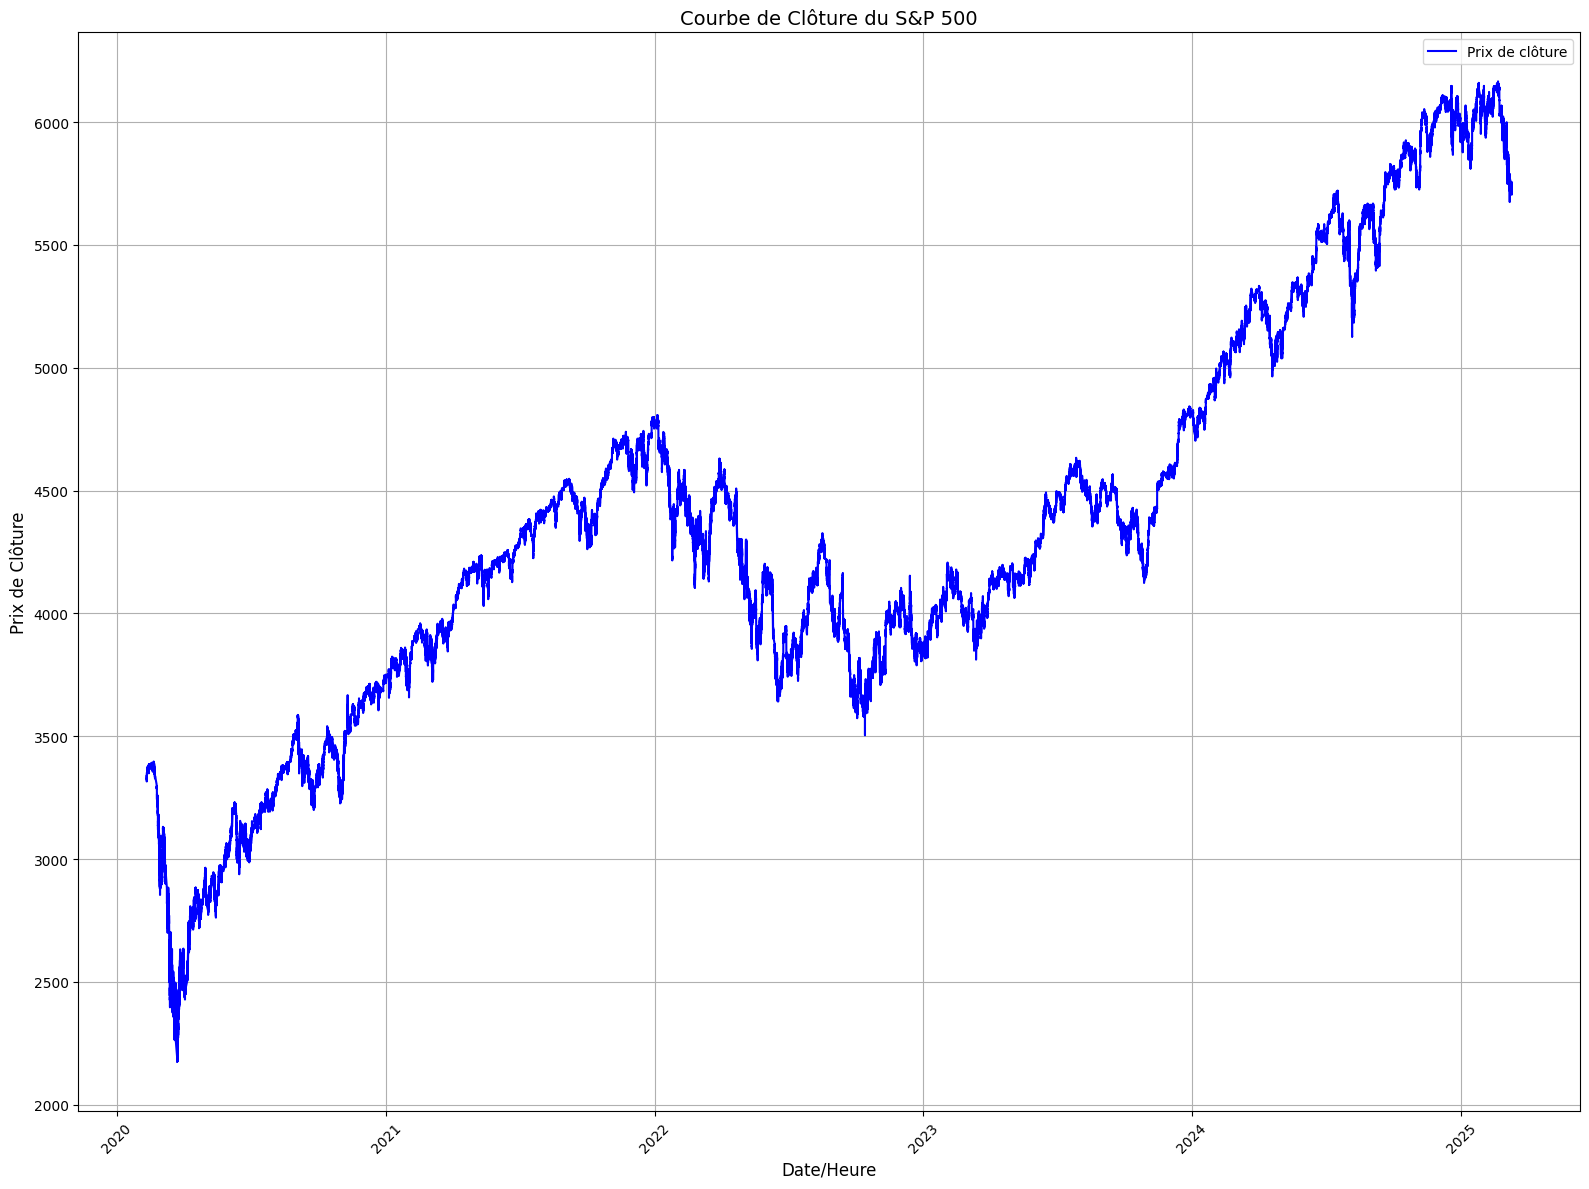

In [33]:
plot_graph_of_df(df_1m_resampled_and_processed)